# Kubernetes Operators: the pythonic way

# Agenda

* Kubernetes Introduction (at fast pace)
* What's a Kubernetes Operator
* Cool tools for Operator development: Kwok And Kopf.

# What Kubernetes is?

Kubernetes is a [Loop](https://fabiensanglard.net/quakeSource/)!

# Are you nuts?

## Let me write it, in Python of course

```python
while True:
    current_state = get_current_state()
    desidered_state = get_desidered_state()
    reconcile(current_state, desidered_state)
```

This is a very high level description of the thing but can help to set the context about what Kubernetes is
* The loop above is called a reconciliation loop, a sort of pattern.
* This enables to be "declarative", just state what you need from the system, not *how* reach a "desidered" condition.

OK, but current and desidered state of what?
* Of the Kubernetes' Resources
* the most important Resources are the **Pods**.

OK, what a **Pod** is?
* A Pod is the tienest thing that Kubernetes can handle, and is basically a set of one of more Containers. Often is just one Container.

Kubernetes is a tool "Orchestrate" a Cluster, basically a set of containers
* that live on a bunch of servers on a LAN called **Nodes**
* all connected in a Pod Network that Kubernetes provides to them.

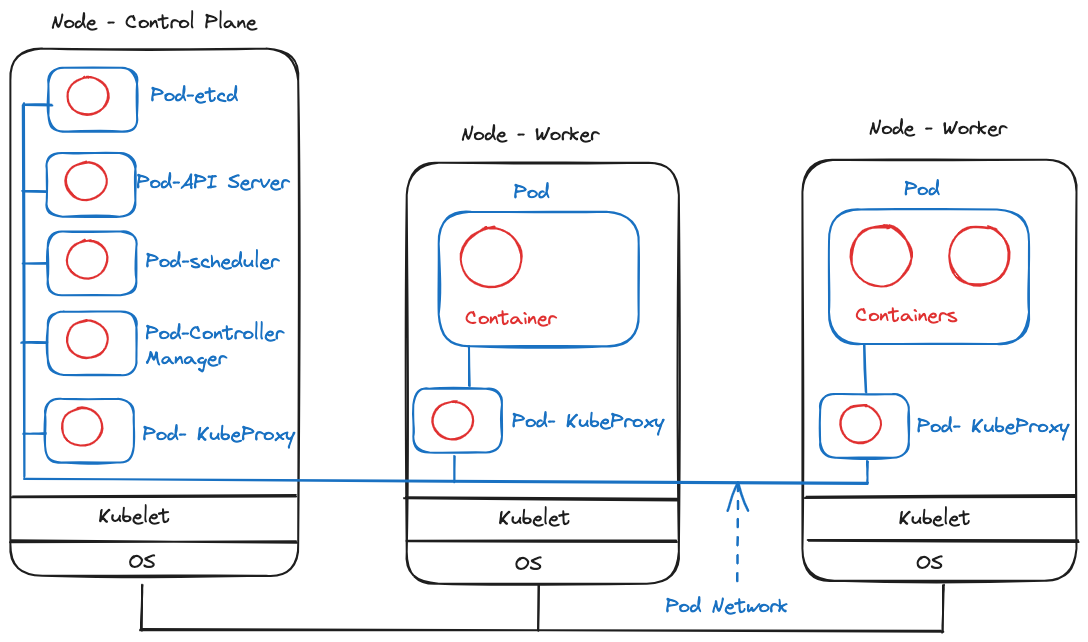

# Why Kubernetes?

Kubernetes fully embrace the concept that containers are ephemeral.

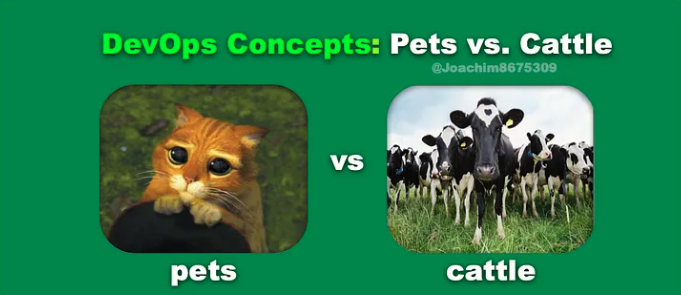

Kubernetes gives a set of "standard" ways to deal with problems you will face when you put your application in production.

# Examples

## High availability
If a Worker Node is lost all Pods are moved in another Node

## Scaling
To cope with high traffic Kubernetes has **Deployments** and **Replicasets** for starting **multiple instances** of an Application.

## Autoscaling
**HorizontalPodAutoscaling** is able to match an increasing demand.

## Services
Kubernetes has the **Service** concept: **decoupling an endpoint** from the actual Pods behind it.
* Remember Pods may crash or scale up, or be moved in another Node.
* A **Service** acts also as **load balancer** among multiple replicated **Pods**.

## Ingress
The are many ways for **exposing a Service outside of the Cluster** via HTTP or HTTPS: **load-balancer**, **Ingress**, **Route**. 

## Dealing with Updates
Kubernetes supports you for updating your application with no downtime providing some update strategies, for example the **RollingUpdate**.

Wrap it up!

* Kubernetes came out many lessons learned by people who actually built a lot of distributed system.
* It's made to build computer clusters and have a standard way to deal with them.
* Has the "single source of truth for the cluster", the etcd database, you can recovery from crashes by doing backups.
* Is API centric.
* **It's declarative!**

# The good news: Kubernetes is extendable
* It's extendable using the [Custom Resource Definition](https://kubernetes.io/docs/concepts/extend-kubernetes/api-extension/custom-resources/)
* Even the loop is extendable, using the [Operator Pattern](https://kubernetes.io/docs/concepts/extend-kubernetes/operator/), you can add custom automation "Behaviour" for your application.

## Why develop a Kubernetes Operator?

Typical use cases:
* Manage complex deployments
* Backup and Recovery
* Security and Compliance
* Performance monitoring and tuning

## What's a Kubernetes Operator?
* The Kubernetes controller is the logic behind most **Resource** objects.
* The **Kubernetes operator is one kind of controller**, and is used to add logic to objects of a specific kind a.k.a Custom Resource.

**In short, Operators are patterns that extend the behavior of the cluster**

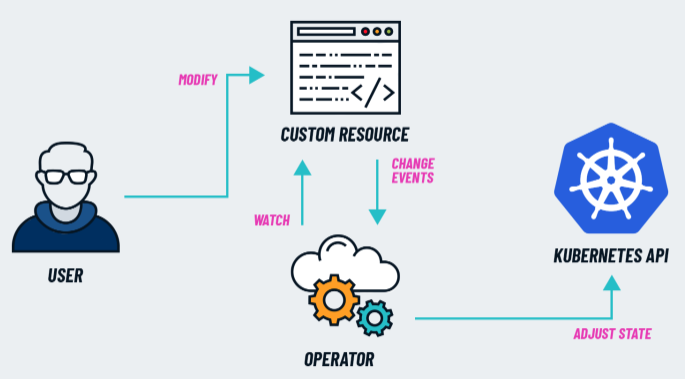
credits: https://www.cncf.io/blog/2022/06/15/kubernetes-operators-what-are-they-some-examples/

## But what **Kind** of Resources we are talking about?
We are talking about [Customer Resource Definition](https://kubernetes.io/docs/concepts/extend-kubernetes/api-extension/custom-resources/), one of the **standard way to extend the Kubernetes API**.

**custom-resource-definition.yaml**

```yaml
apiVersion: apiextensions.k8s.io/v1
kind: CustomResourceDefinition
metadata:
  name: kopfexamples.kopf.dev
spec:
  scope: Namespaced
  group: kopf.dev
  names:
    kind: KopfExample
    plural: kopfexamples
    singular: kopfexample
```

**custom-resource-instance.yaml**
```yaml
apiVersion: kopf.dev/v1
kind: KopfExample
metadata:
  name: kopf-example-1
  labels:
    somelabel: somevalue
  annotations:
    someannotation: somevalue
spec:
  duration: 1m
  field: value
```

## An OOP Analogy

```python
class KopfExample:
    """CustomResourceDefinition is 'like' a class definition"""
```

```shell
kubectl apply -f custom-resource-definition.yaml
```

```python
# After definition is possible create an instance
instance = KopfExample()
```

```shell
kubectl apply -f custom-resource-instance.yaml
```

A **Kubernetes Operator** basically **gives you code Hooks that are called on events on the custom Resource objects**.
* Events like: create, read, update, delete.

# Two cool tools for Operators' development

# KWOK

[Kubernetes without Kubelet](https://kwok.si) **a Kubernetes "emulator"**.

* Nodes and Pods are fake
* You have just the Control Plane

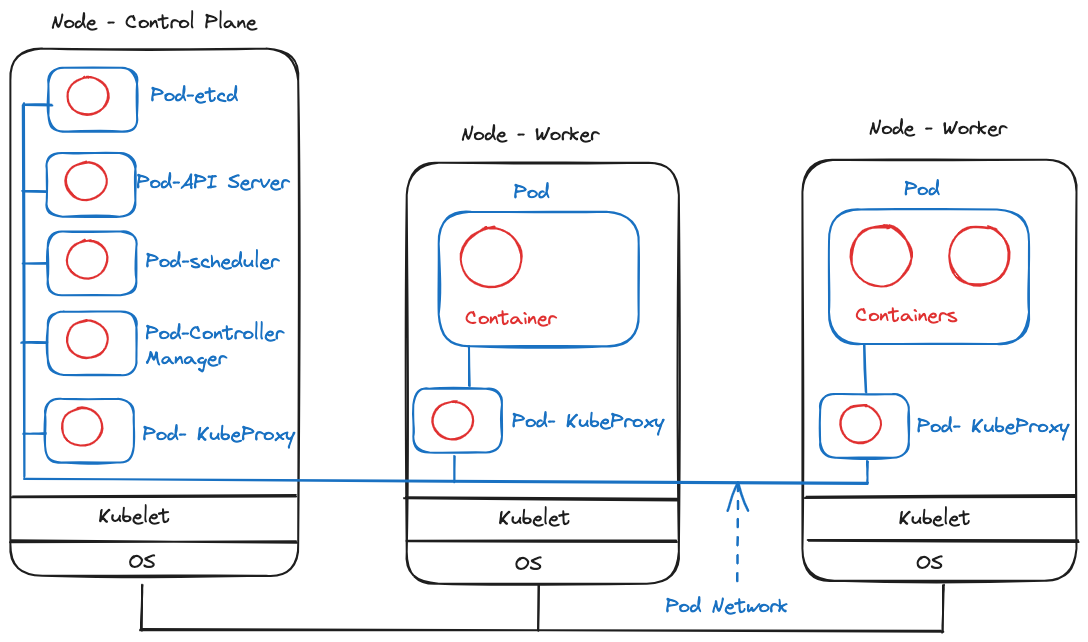

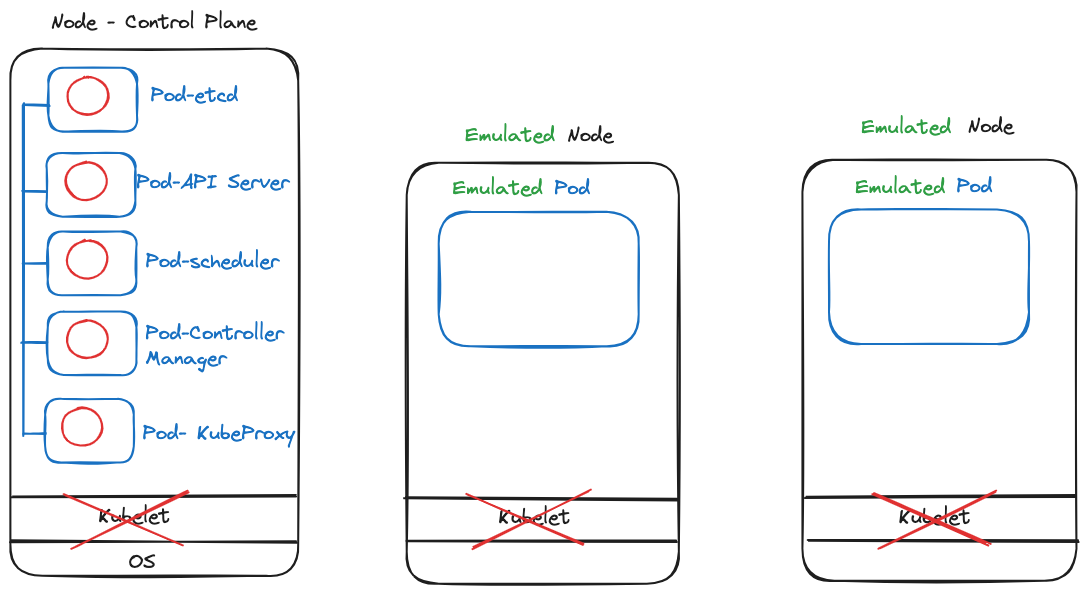

# KWOK installation

`podman run --rm -it -p 8080:8080 registry.k8s.io/kwok/cluster:v0.4.0-k8s.v1.28.0`

## Why using KWOK?

* It's a nice tool for Operator's development on your PC.
* It's lightweight for both CPU and memory.
* You can test your Operator at scale: ~ 1000 emulated nodes, ~ 100K emulated pods.

# KOPF
[Kubernetes Operator Pythonic Framework](https://kopf.readthedocs.io/en/stable/)

It's a way to write Operator in Python

## Example add a label on Create events

```python
import kopf
from kubernetes import client
from kubernetes import config

@kopf.on.create('kopfexamples')
def create_fn(spec, name, **kwargs):
    config.load_kube_config()
    # Add a label
    patch_label = {"metadata": {"labels": {"kopf-operated": "true"}}}
    api = client.CustomObjectsApi()
    patched_resource = api.patch_namespaced_custom_object(
        group="kopf.dev",
        version="v1",
        plural="kopfexamples",
        namespace="default",
        name=name,
        body=patch_label,
    )
    return {'message': 'hello world'}
```

## Start the operator

```shell
export KUBECONFIG=~/.kube/config.kwok
export PYTHONUNBUFFERED=1

kopf run label_oper.py --verbose
```

# Demo time!
Custom Resource Definition -> CR -> Operator

## TIL
* Use `PYTHONUNBUFFERED=1` otherwise your operator will not print stuff.
* The use Kopf and Kwok gives you the typical **"rapid turnaround"** experience you have when using Python.

## For production you can add the Operator as a Pod.

```Dockerfile
ENV PYTHONUNBUFFERED 1
FROM python:3.11
RUN mkdir /src
ADD label_oper.py /src
RUN pip install kopf
RUN pip install kubernetes
CMD kopf run /src/label_oper.py --verbose
```

The build the image

```shell
podman build -t label-inc/label-operator .
podman push label-inc/label-operator
```

And deploy to Kubernetes

```yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: label-operator
spec:
  replicas: 1
  strategy:
    type: Recreate
  selector:
    matchLabels:
      application: label-operator
  template:
    metadata:
      labels:
        application: label-operator
    spec:
      serviceAccountName: label-inc-account
      containers:
      - name: label-inc
        image: label-inc/label-operator
```

## Native Operator Development
Here is some Native Golang Operator development information

* https://sdk.operatorframework.io/ to build operators using Golang, Ansible, Helm.
* https://book.kubebuilder.io/


### A comparison with Go using kubebuilder
```shell
curl -L -o kubebuilder "https://go.kubebuilder.io/dl/latest/$(go env GOOS)/$(go env GOARCH)"
chmod +x kubebuilder && mv kubebuilder /usr/local/bin/

mkdir ~/src/native-label-operator
cd ~/src/native-label-operator

kubebuilder init --domain pycon.it --repo pycon.it/native-label-operator
kubebuilder create api --group kopf.dev --version v1 --kind KopfExample
```

```tree
.
├── Dockerfile
├── Makefile
├── PROJECT
├── README.md
├── api
│   └── v1
│       ├── groupversion_info.go
│       ├── kopfexample_types.go
│       └── zz_generated.deepcopy.go
├── bin
│   └── controller-gen-v0.14.0
├── cmd
│   └── main.go
├── config
│   ├── crd
│   │   ├── kustomization.yaml
│   │   └── kustomizeconfig.yaml
│   ├── default
│   │   ├── kustomization.yaml
│   │   ├── manager_config_patch.yaml
│   │   └── manager_metrics_patch.yaml
│   ├── manager
│   │   ├── kustomization.yaml
│   │   └── manager.yaml
│   ├── prometheus
│   │   ├── kustomization.yaml
│   │   └── monitor.yaml
│   ├── rbac
│   │   ├── kopfexample_editor_role.yaml
│   │   ├── kopfexample_viewer_role.yaml
│   │   ├── kustomization.yaml
│   │   ├── leader_election_role.yaml
│   │   ├── leader_election_role_binding.yaml
│   │   ├── metrics_service.yaml
│   │   ├── role.yaml
│   │   ├── role_binding.yaml
│   │   └── service_account.yaml
│   └── samples
│       ├── kopf.dev_v1_kopfexample.yaml
│       └── kustomization.yaml
├── go.mod
├── go.sum
├── hack
│   └── boilerplate.go.txt
├── internal
│   └── controller
│       ├── kopfexample_controller.go
│       ├── kopfexample_controller_test.go
│       └── suite_test.go
└── test
    ├── e2e
    │   ├── e2e_suite_test.go
    │   └── e2e_test.go
    └── utils
        └── utils.go

```

# A 5G use case

Disclaimer: no graphene will be implanted in your brains.

[Zero Touch Provisioning](https://github.com/openshift-kni/cnf-features-deploy/tree/master/ztp/gitops-subscriptions/argocd#gitops-ztp-pipeline): a way to massively install servers with Openshift.
* Openshift it's a Kubernetes "distro".

* ZTP it's a GitOps Flow.
* All operations on the clusters are written in a git repository.
* The `SiteConfig` Argocd's application **installs and put labels the clusters**.
* The `PolicyGenTemplate` Argocd's application **applies Configurations to "spoke clusters"** that have a particular label.

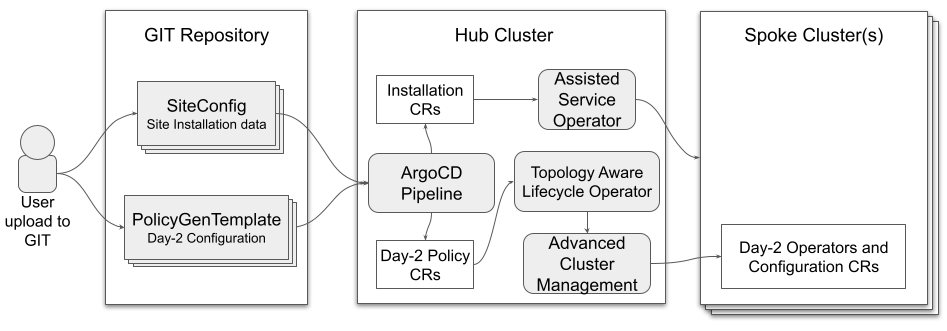

# Problem
My use case: **I MUST use ZTP** for configurations, but **my clusters are pre-installed and have no labels**.

# Solution

By looking at the [code of the Topology Aware Lifecycle Operator](https://github.com/openshift-kni/cluster-group-upgrades-operator/blob/299387e4053e111ed3d586d9d3c880ada147859b/controllers/managedclusterForCGU_controller.go#L129), is possible to see that policies are applied after the `ManagedCluster` Custom Resorce transition to `Available` state. This happens after the `ManagedCluster` object creation.

```go
func (r *ManagedClusterForCguReconciler) Reconcile(ctx context.Context, req ctrl.Request) (ctrl.Result, error) {

    availableCondition := meta.FindStatusCondition(managedCluster.Status.Conditions, clusterv1.ManagedClusterConditionAvailable)
    if availableCondition == nil {
        return r.handleNotReadyCluster(managedCluster), nil
        // HERE the spoke cluster is discovered
    } else if availableCondition.Status == metav1.ConditionTrue {
        // create clusterGroupUpgrade, this applies configurations if labes are matched
        if err := r.newClusterGroupUpgrade(ctx, managedCluster, policies); err != nil {
            return ctrl.Result{}, err
        }
    } else {
        return r.handleNotReadyCluster(managedCluster), nil
    }
    return doNotRequeue(), nil
}
```

So, **if I wrote an operator to label the** `ManagedCluster` **on create**, it would be possible that I can use ZTP on a preinstalled cluster.

Using KOPF I was able to check this in minutes!

```python
@kopf.on.create('managedclusters.cluster.open-cluster-management.io')
def create_fn(spec, name, **kwargs):
    if name == "local-cluster":
       return
    config.load_kube_config()
    # Add these labels to apply policies
    labels = {"common": "4.12", "group-du-sno": "du-lowband"}
    patch_label = {"metadata": {"labels": labels}}
    api = client.CustomObjectsApi()
    patched_resource = api.patch_cluster_custom_object(
        group="cluster.open-cluster-management.io",
        version="v1",
        plural="managedclusters",
        name=name,
        body=patch_label,
    )
```

## Take homes
* Kwok it's very useful to have a bench for experimenting Operator development.
* Kwok can emulate any number of Nodes and Pods, you can test your Operators at scale.
* Kopf enables you to write an Operator very quickly.
* Kopf can be used to investigate or debug the lifecycle of any Resource (i.e. the ZTP use case).

# And that's it!
Cesare Placanica
Senior Software Engineer @ RedHat